In [1]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 7.9 MB/s eta 0:00:00


In [2]:
!pip install ultralytics

from ultralytics import YOLO
import supervision as sv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.7/871.7 kB 27.5 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/client work/0828.mp4"
TARGET_VIDEO_PATH = "/content/drive/MyDrive/client project/result.mp4"

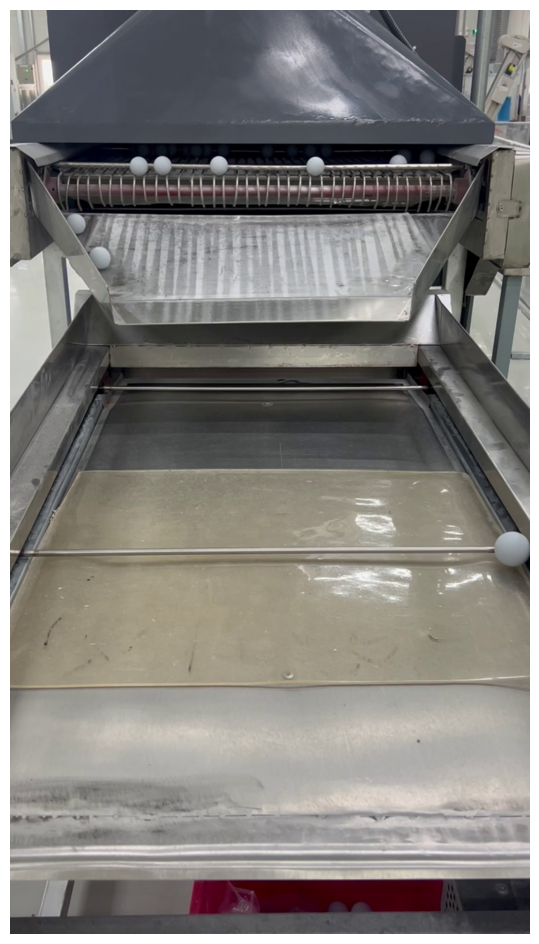

In [8]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (12, 12))

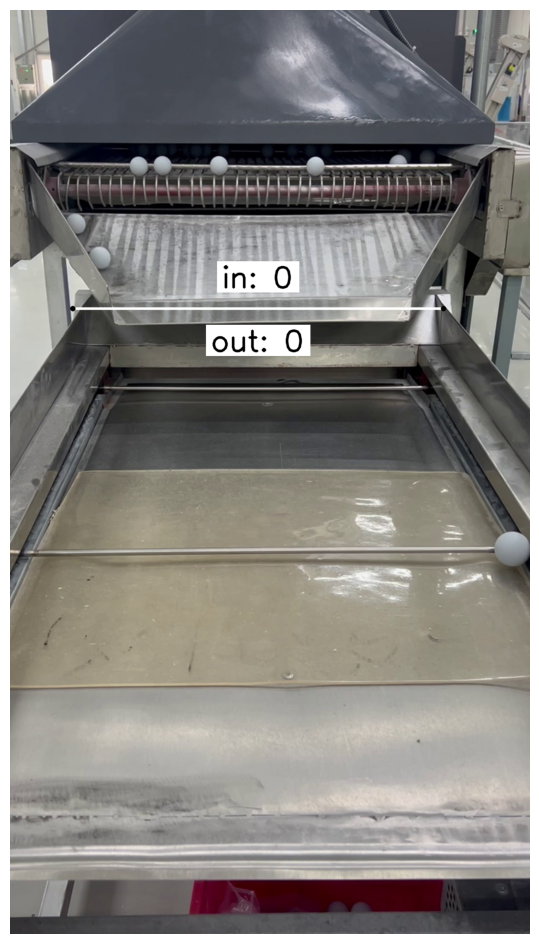

In [13]:
START = sv.Point(130, 620)
END = sv.Point(900, 620)



line_zone = sv.LineZone(start=START, end=END)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4,
    text_thickness=4,
    text_scale=2)


annotated_frame = line_zone_annotator.annotate(frame.copy(), line_counter=line_zone)
sv.plot_image(annotated_frame, (12, 12))

In [17]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

# Initialize the model and annotators outside the callback
model = YOLO("/content/drive/MyDrive/client work/best (4).pt")  # custom model for ball

START = sv.Point(130, 620)
END = sv.Point(900, 620)

BALL_ID = 0  # Ball class ID
byte_tracker = sv.ByteTrack()  # Fine-tune ByteTrack parameters



def callback(frame: np.ndarray, index: int) -> np.ndarray:


    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Update detections with the tracker, keeping the tracker state across frames
    detections = byte_tracker.update_with_detections(detections)

    # Filter ball detections
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # Generate labels with tracker IDs, check for double counting
    labels = [f"#{tracker_id}" for tracker_id in detections.tracker_id]
    for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):

            labels.append(f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}")


    # Annotate the frame
    annotated_frame = frame.copy()


    # Trigger and annotate line zone (assuming you have line_zone and line_zone_annotator properly defined)
    line_zone.trigger(detections)
    annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

    return annotated_frame


In [18]:
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)